<a href="https://colab.research.google.com/github/dp1500/credit-card-default-predictions-using-machine-learning/blob/main/credit_card_default_predictions_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting whether a given credit card account will default based on past credit card defaults data containing account holder information, using ensemble methods

## Importing Necessary Libraries

In [196]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import pydotplus
from sklearn.metrics import classification_report
from google.colab import files

## getting the Credit Card Dataset:
> 1) app_df has the application data

> 2) cr_df has the credit status



In [197]:
app_df = pd.read_csv('/content/application_record.csv')
cr_df = pd.read_csv('/content/credit_record.csv')

In [198]:
app_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [199]:
cr_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [200]:
cr_df.shape

(1048575, 3)

In [201]:
cr_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## data cleaning and engineering

Preparing the Target Variable:

1. For customers having due for multiple months, the maximum number of months due is taken
2.   Any ID with greater than equal to 1 months due is marked as Class '1'



In [202]:
cr_df['MONTHS_BALANCE'].value_counts()

-1     34436
-2     34209
 0     33856
-3     33854
-4     33365
       ...  
-56     2109
-57     1649
-58     1255
-59      820
-60      415
Name: MONTHS_BALANCE, Length: 61, dtype: int64

In [203]:
cr_df = cr_df.sort_values(['ID','MONTHS_BALANCE'], ascending=False)
cr_df = cr_df.groupby('ID').agg(max).reset_index()

Status:


> 0: 1-29 days past due

> 1: 30-59 days past due

> 2: 60-89 days overdue

> 3: 90-119 days overdue

> 4: 120-149 days overdue

> 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month








In [204]:
cr_df['STATUS'].value_counts()

X    25005
C    14882
0     5161
1      821
5       54
2       49
3       10
4        3
Name: STATUS, dtype: int64

In [205]:
cr_df.shape

(45985, 3)

'''converting labels 0 to 5 into 0 and 1, where 1 are defaulted ones''' 

In [206]:
cr_df['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
cr_df['STATUS'] = cr_df['STATUS'].astype('int')
cr_df['STATUS'] = cr_df['STATUS'].apply(lambda x:1 if x > 0 else 0)
cr_df['STATUS'].value_counts()

0    45048
1      937
Name: STATUS, dtype: int64

Merging both Application and Credit Status Datasets

In [207]:
df = app_df.join(cr_df.set_index('ID'), on='ID', how='inner')
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 434812
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
MONTHS_BALANCE             0
STATUS                     0
dtype: int64

Getting the split of Binary Classes in our dataset

In [208]:
df['STATUS'].value_counts()

0    35689
1      768
Name: STATUS, dtype: int64

In [209]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-22,0


Different Types of Features based on DataType

In [210]:
binary_features = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_WORK_PHONE','FLAG_EMAIL']
continous_features = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS']
cat_features = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 434812
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null

In [212]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-5.831802,0.021066
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,11.326494,0.143606
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-6.000000,0.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,1.000000


Dropping Features:


1.   'OCCUPATION_TYPE' - Lot of Missing data (11323 data points)
2. 'FLAG_MOBIL' - All datapoints have the flag set to 1






In [213]:
df.drop(['MONTHS_BALANCE','OCCUPATION_TYPE','FLAG_MOBIL'], axis=1, inplace=True)

Ordering Ordinal Values and Encoding:
We have determined the order of the income type (a qualitative call) and created the encoding of the variable 'NAME_INCOME_TYPE'

In [214]:
df['NAME_INCOME_TYPE'].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

In [215]:
encoder = OrdinalEncoder(categories=[['Student', 'Pensioner', 'Working','Commercial associate','State servant']])

df.NAME_INCOME_TYPE = encoder.fit_transform(df.NAME_INCOME_TYPE.values.reshape(-1, 1))

df['NAME_INCOME_TYPE'].unique()

array([2., 3., 1., 4., 0.])

## data transformation

### Encoding Ordinal Columns without Ordering

In [216]:
encoder2 = LabelEncoder()

# No specific order for other Categorical Variables
cat_features = ['NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']
for i in cat_features:
  df[i] = encoder2.fit_transform(df[i].values.reshape(-1, 1))

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [217]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,2.0,1,0,4,-12005,-4542,1,0,0,2.0,0
1,5008805,M,Y,Y,0,427500.0,2.0,1,0,4,-12005,-4542,1,0,0,2.0,0
2,5008806,M,Y,Y,0,112500.0,2.0,4,1,1,-21474,-1134,0,0,0,2.0,0
3,5008808,F,N,Y,0,270000.0,3.0,4,3,1,-19110,-3051,0,1,1,1.0,0
4,5008809,F,N,Y,0,270000.0,3.0,4,3,1,-19110,-3051,0,1,1,1.0,0


### For binary features we had used PANDAS DUMMIES for one hot encoding

In [218]:
#Getting dummies using Pandas
df = pd.get_dummies(df, columns=binary_features, drop_first=True)

In [219]:
df.head()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_PHONE,CNT_FAM_MEMBERS,STATUS,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_WORK_PHONE_1,FLAG_EMAIL_1
0,5008804,0,427500.0,2.0,1,0,4,-12005,-4542,0,2.0,0,1,1,1,1,0
1,5008805,0,427500.0,2.0,1,0,4,-12005,-4542,0,2.0,0,1,1,1,1,0
2,5008806,0,112500.0,2.0,4,1,1,-21474,-1134,0,2.0,0,1,1,1,0,0
3,5008808,0,270000.0,3.0,4,3,1,-19110,-3051,1,1.0,0,0,0,1,0,1
4,5008809,0,270000.0,3.0,4,3,1,-19110,-3051,1,1.0,0,0,0,1,0,1


In [220]:
# copying data for outlier removal
df_with_outliers = df.copy()

### Plotting different variables to get an understanding of outliers present

<AxesSubplot:xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

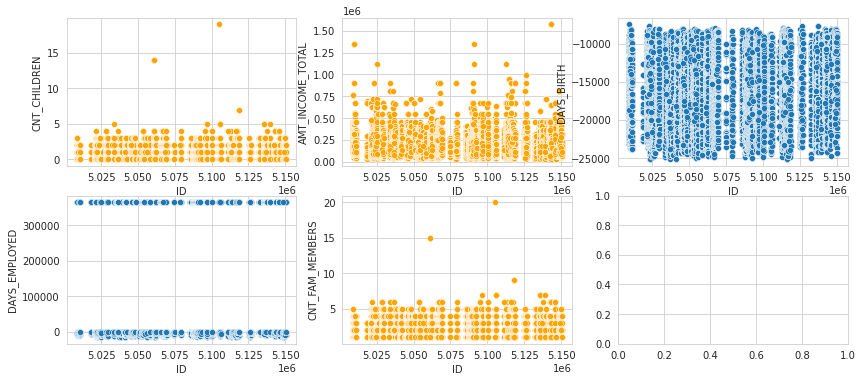

In [221]:
# Plotting different Variables
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=df, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=df, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=df, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=df, ax=ax[1][0])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=df, ax=ax[1][1], color= 'orange')

<AxesSubplot:>

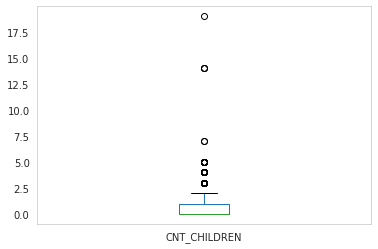

In [222]:
df.boxplot(column =['CNT_CHILDREN'], grid = False)

<AxesSubplot:ylabel='CNT_FAM_MEMBERS'>

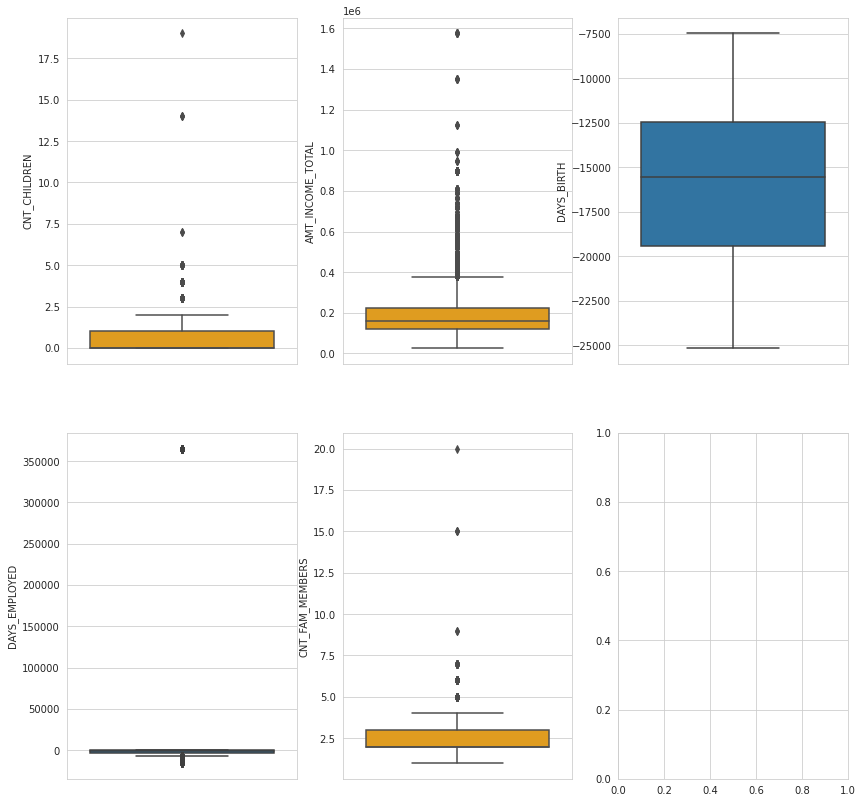

In [223]:
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (14,14))

# sns.set_style("whitegrid")


sns.boxplot(y='CNT_CHILDREN', data=df, ax=ax[0][0], color= 'orange')
sns.boxplot(y='AMT_INCOME_TOTAL', data=df, ax=ax[0][1], color='orange')
sns.boxplot(y='DAYS_BIRTH', data=df, ax=ax[0][2])
sns.boxplot(y='DAYS_EMPLOYED', data=df, ax=ax[1][0])
sns.boxplot(y='CNT_FAM_MEMBERS', data=df, ax=ax[1][1], color= 'orange')





as we can see in the above boxplot there definitely alot of unclean data , example: people having more than 12 children etc.

In [224]:
df.shape

(36457, 17)

### Removing Outliers using IQR Technique

In [225]:
q_hi = df['AMT_INCOME_TOTAL'].quantile(0.75)
q_low = df['AMT_INCOME_TOTAL'].quantile(0.25)
IQR = q_hi - q_low
lower_range = q_low - (1.5 * IQR)
upper_range = q_hi + (1.5 * IQR)
df= df[(df['AMT_INCOME_TOTAL']>lower_range) & (df['AMT_INCOME_TOTAL']<upper_range)]
df= df[(df['CNT_CHILDREN'] < 8)]
df= df[(df['CNT_FAM_MEMBERS'] < 8)]

df.shape

(34922, 17)

In [226]:
df_with_outliers.shape

(36457, 17)

<AxesSubplot:xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

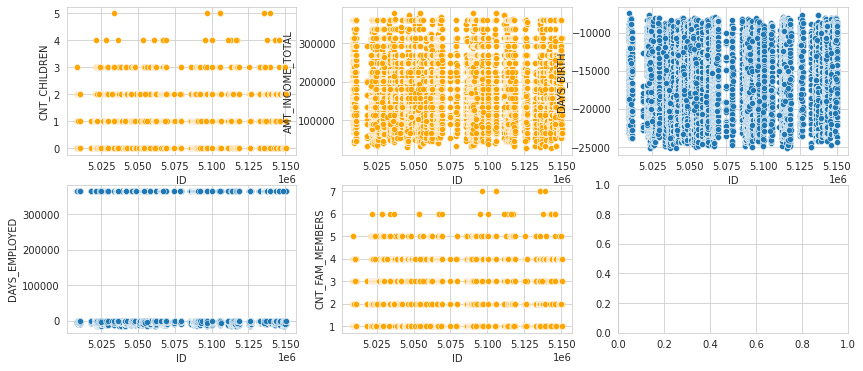

In [227]:
# Plotting post removal of outliers
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=df, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=df, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=df, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=df, ax=ax[1][0])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=df, ax=ax[1][1], color= 'orange')

### Train Test Split for removed outliers dataframe:

1.   Seperating Target Variable from the dataset
2.   Creating Train Test Split
3. Transforming the data
4. Using SMOTE to counter imbalance in the data



In [234]:
new_cols = [col for col in df.columns if col != 'STATUS'] + ['STATUS']
df = df[new_cols]

X_train_feature_importance = df.iloc[:,1:-1]

X = df.iloc[:,1:-1].values
y = df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

# sm = SMOTE(random_state = 42)
# X_train_res, y_train_res = sm.fit_resample(X_scaled, y_train)


## model building

### Defining the DecisionTreeClassifier Model

In [235]:
classifier = DecisionTreeClassifier()
model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

Model Performance Metrics

In [236]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, prediction)))
print(pd.DataFrame(confusion_matrix(y_test,prediction)))

Accuracy Score is 0.97394
      0   1
0  6780  46
1   136  23


In [237]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6826
           1       0.33      0.14      0.20       159

    accuracy                           0.97      6985
   macro avg       0.66      0.57      0.59      6985
weighted avg       0.97      0.97      0.97      6985



### Feature Importance

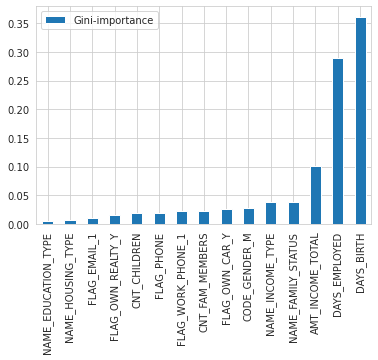

In [238]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_feature_importance.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)
model.feature_importances_
importances = model.feature_importances_
indices = np.argsort(importances)

### Trying out ensemble methods


#### random forest

#### without oversampling

In [239]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=10,n_estimators=300, random_state=0)
model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

In [240]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, prediction)))
print()
print(pd.DataFrame(confusion_matrix(y_test,prediction)))
print()
print()
print(classification_report(y_test, prediction))

Accuracy Score is 0.97724

      0  1
0  6826  0
1   159  0


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6826
           1       0.00      0.00      0.00       159

    accuracy                           0.98      6985
   macro avg       0.49      0.50      0.49      6985
weighted avg       0.95      0.98      0.97      6985



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [241]:
from sklearn.metrics import f1_score
f1_score(y_test, prediction, average='macro')

0.49424371877488954

In [242]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(max_depth=15,n_estimators=900,learning_rate=0.01)

model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

In [243]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, prediction)))
print()
print(pd.DataFrame(confusion_matrix(y_test,prediction)))
print()
print()
print(classification_report(y_test, prediction))

Accuracy Score is 0.97581

      0   1
0  6793  33
1   136  23


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6826
           1       0.41      0.14      0.21       159

    accuracy                           0.98      6985
   macro avg       0.70      0.57      0.60      6985
weighted avg       0.97      0.98      0.97      6985



In [244]:
from sklearn.metrics import f1_score
f1_score(y_test, prediction, average='macro')

0.600833523539009

#### with oversampling


In [245]:
new_cols = [col for col in df.columns if col != 'STATUS'] + ['STATUS']
df = df[new_cols]


X = df.iloc[:,1:-1].values
y = df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_resample(X_train, y_train)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(max_depth=10,n_estimators=800,learning_rate=0.01)

model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

In [ ]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, prediction)))
print()
print(pd.DataFrame(confusion_matrix(y_test,prediction)))
print()
print()
print(classification_report(y_test, prediction))

### model for dataframe with outliers

In [ ]:
df_with_outliers= df_with_outliers[(df_with_outliers['CNT_CHILDREN'] < 8)]
df_with_outliers= df_with_outliers[(df_with_outliers['CNT_FAM_MEMBERS'] < 8)]

In [ ]:
new_cols = [col for col in df_with_outliers.columns if col != 'STATUS'] + ['STATUS']
df_with_outliers = df_with_outliers[new_cols]


X = df_with_outliers.iloc[:,1:-1].values
y = df_with_outliers.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

# sm = SMOTE(random_state = 42)
# X_train_res, y_train_res = sm.fit_resample(X_scaled, y_train)


#### random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=1,n_estimators=100, random_state=0)
model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

In [ ]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, prediction)))
print()
print(pd.DataFrame(confusion_matrix(y_test,prediction)))
print()
print()
print(classification_report(y_test, prediction))

#### XGBoost

In [ ]:
import xgboost as xgb
classifier = xgb.XGBClassifier(max_depth=15,n_estimators=900,learning_rate=0.05)



model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)


In [ ]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, prediction)))
print()
print(pd.DataFrame(confusion_matrix(y_test,prediction)))
print()
print()
print(classification_report(y_test, prediction))

#### Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(max_depth=15,n_estimators=900,learning_rate=0.01)

model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

In [ ]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, prediction)))
print()
print(pd.DataFrame(confusion_matrix(y_test,prediction)))
print()
print()
print(classification_report(y_test, prediction))

##### trying with oversampling now for gradient boost

In [ ]:
new_cols = [col for col in df_with_outliers.columns if col != 'STATUS'] + ['STATUS']
df_with_outliers = df_with_outliers[new_cols]


X = df_with_outliers.iloc[:,1:-1].values
y = df_with_outliers.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_resample(X_train, y_train)


In [ ]:
X_train.shape

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(max_depth=15,n_estimators=800,learning_rate=0.05)

model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

In [ ]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, prediction)))
print()
print(pd.DataFrame(confusion_matrix(y_test,prediction)))
print()
print()
print(classification_report(y_test, prediction))

## **Conclusion** : the best predictions are provided by gradient boost classifier where outliers have been removed and oversampling is not used
> overall accuracy of 97.91%


> F-1 score: 63%







